In [1]:
import numpy as np
import itertools
import time
import sys

from data_pre import data_preprocessing
from misc import compute_prob_log,compute_tag_acc
from inference import local_predictor, greedy_LR_predictor, greedy_RL_predictor, Viterbi_predictor,beam_search_predictor

# Supervised Parameter Estimation for HMMs

Implemented in `code/data_pre.py`

(I add `sys.float_info.min` below to 0 entry just to suppress warning message. )

In [2]:
(data_train,data_dev,word2ix, ix2word, tag2ix, ix2tag, em_prob, trans_prob) = data_preprocessing()

In [3]:
em_prob[em_prob == 0] = sys.float_info.min
trans_prob[trans_prob == 0] = sys.float_info.min

In [4]:
top_tag = 5
ix_sorted = np.argsort(trans_prob[tag2ix['<s>'],:])[::-1]
ix = ix_sorted[:top_tag]
print("top {} tags with after '<s>' and probablity:".format(top_tag))
for i in ix:
    print("{} : {}".format(ix2tag[i],trans_prob[tag2ix['<s>'],i] ))

top 5 tags with after '<s>' and probablity:
PRP : 0.22450589735416002
NNP : 0.11596270321963659
DT : 0.11237647433854
IN : 0.07810806503028371
RB : 0.06567580490914887


In [5]:
top_word = 10
ix_sorted = np.argsort(em_prob[tag2ix['JJ'],:])[::-1]
ix = ix_sorted[:top_word]
print("top {} words with tag 'JJ' and probablity:".format(top_word))
for i in ix:
    print("{} : {}".format(ix2word[i],em_prob[tag2ix['JJ'],i] ))

top 10 words with tag 'JJ' and probablity:
other : 0.023068970800645242
good : 0.021605646023457964
new : 0.01678528205154691
great : 0.013686476641032664
many : 0.013686476641032664
same : 0.011362372583146978
sure : 0.009554736093680334
last : 0.009210424381400972
few : 0.008952190597191451
little : 0.00843572302877241


# Preliminaries for Inference with HMMs 

## Log-probability calculation
code is in `code/misc.py/`

In [6]:
(corpus, tags) = data_dev
print("log probability of dev is {}".format(compute_prob_log(corpus, tags, trans_prob, em_prob, word2ix, tag2ix)))

log probability of dev is -169936.39757772238


## Local predictor baseline

Implemented in `code/inference.py`

In [7]:
(corpus, tags) = data_dev
start = time.time()
tags_pred = local_predictor(corpus, em_prob, word2ix, ix2tag)   
runtime = time.time() - start
print("baseline accuracy using local predictor is {}".format(compute_tag_acc(tags_pred, tags)))
print("log prob of baseline prediction is {}".format(compute_prob_log(corpus, tags_pred, trans_prob, em_prob, word2ix, tag2ix)))
print("runtime for local predictor is {}".format(runtime))

baseline accuracy using local predictor is 0.7988866799204771
log prob of baseline prediction is -186408.123975879
runtime for local predictor is 0.02616119384765625


# Greedy Left-to-Right Algorithm

Implemented in `code/inference.py`

In [8]:
(corpus, tags) = data_dev
start = time.time()
tags_pred = greedy_LR_predictor(corpus, em_prob, trans_prob, word2ix, tag2ix, ix2tag) 
runtime = time.time() - start
print("accuracy using greedy lr predictor is {}".format(compute_tag_acc(tags_pred, tags)))
print("log prob of greedy lr predictor is {}".format(compute_prob_log(corpus, tags_pred, trans_prob, em_prob, word2ix, tag2ix)))
print("runtime for greedy lr predictor is {}".format(runtime))

accuracy using greedy lr predictor is 0.8739165009940358
log prob of greedy lr predictor is -166274.29614950533
runtime for greedy lr predictor is 0.18198919296264648


# Greedy Right-to-Left Algorithm

Implemented in `code/inference.py`

In [9]:
(corpus, tags) = data_dev
start = time.time()
tags_pred = greedy_RL_predictor(corpus, em_prob, trans_prob, word2ix, tag2ix, ix2tag) 
runtime = time.time() - start
print("accuracy using greedy rl predictor is {}".format(compute_tag_acc(tags_pred, tags)))
print("log prob of greedy rl predictor is {}".format(compute_prob_log(corpus, tags_pred, trans_prob, em_prob, word2ix, tag2ix)))
print("runtime for greedy rl predictor is {}".format(runtime))

accuracy using greedy rl predictor is 0.8001590457256461
log prob of greedy rl predictor is -176754.9009696138
runtime for greedy rl predictor is 0.16004109382629395


## Discuss the result:
* Accuracy is much worse than Left-to-Right, very close to our local predictor baseline. 

* Log-probability, though worse than Left-to-Right, is much better than that of local predictor baseline

* It seems that Right-to-Left learns rather "blindly" from our estimated transmission probability

* It depends on the English grammar: given the current word one can determine the tag of the next word , than  the previous word (for example, "the" most probably be followed by a noun, but the reverse is probably not true). In other words, the distribution is more spiky in the rows of transmission probability matrix than  its column. (the maximum of rows and columns of transition probability matrix shown below)

* Although probably much worse than Left-to-Right in general, there might be some rare case when Right-to-Left may be more useful.Therefore, to improve upon it, we may combine the two direction: when for example left-to-right finds itself facing a few equally likelily candidate, the model might make the decision based on Right-to-Left result.   

max conditional probability for next word


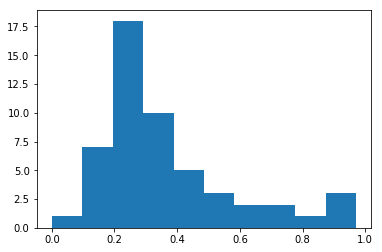

max conditional probability for previous word


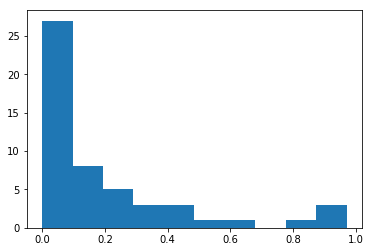

In [18]:
print("max conditional probability for next word")
plt.hist(trans_prob.max(axis = 1))
plt.show()
print("max conditional probability for previous word")
plt.hist(trans_prob.max(axis = 0))
plt.show()

# Exact Inference with Viterbi

Implemented in `code/inference.py`

In [10]:
(corpus, tags) = data_dev
start = time.time()
tags_pred = Viterbi_predictor(corpus, em_prob, trans_prob, word2ix, tag2ix, ix2tag) 
runtime = time.time() - start
print("accuracy using Viterbi_predictor is {}".format(compute_tag_acc(tags_pred, tags)))
print("log prob of Viterbi_predictor is {}".format(compute_prob_log(corpus, tags_pred, trans_prob, em_prob, word2ix, tag2ix)))
print("runtime for Viterbi_predictor is {}".format(runtime))

accuracy using Viterbi_predictor is 0.8941153081510934
log prob of Viterbi_predictor is -163206.89965932094
runtime for Viterbi_predictor is 1.9520409107208252


In [11]:
bs = [1,2,3,4,5,10,20,50, 1000] ## b = 1000 would take > 10 min

accs = []
runtimes = []
log_probs = []

(corpus, tags) = data_dev
print("accuracy, time, logprobablity for beam search with different b")
for b in bs:
    print("b = {}".format(b))
    start = time.time()
    tags_pred = beam_search_predictor(corpus, em_prob, trans_prob, word2ix, tag2ix, ix2tag,b) 
    
    runtime = time.time() - start
    acc = compute_tag_acc(tags_pred, tags)
    log_prob = compute_prob_log(corpus, tags_pred, trans_prob, em_prob, word2ix, tag2ix)
    
    accs.append(acc)
    log_probs.append(log_prob)
    runtimes.append(runtime)
    
    print("accuracy: {}".format(acc))
    print("log prob: {}".format(log_prob))
    print("runtime : {}".format(runtime))

accuracy, time, logprobablity for beam search with different b
b = 1
accuracy: 0.8739165009940358
log prob: -166274.29614950533
runtime : 0.6889479160308838
b = 2
accuracy: 0.8886282306163021
log prob: -164195.42520671518
runtime : 1.3856902122497559
b = 3
accuracy: 0.8913320079522863
log prob: -163687.5695046997
runtime : 2.0054268836975098
b = 4
accuracy: 0.8924055666003976
log prob: -163559.71852448894
runtime : 2.6391260623931885
b = 5
accuracy: 0.8936381709741551
log prob: -163473.45650404942
runtime : 3.478754997253418
b = 10
accuracy: 0.8941153081510934
log prob: -163346.67640824596
runtime : 6.580466032028198
b = 20
accuracy: 0.8939562624254473
log prob: -163315.09466568255
runtime : 14.01413869857788
b = 50
accuracy: 0.8939165009940357
log prob: -163295.48961715284
runtime : 36.665101766586304
b = 1000
accuracy: 0.8939960238568588
log prob: -163292.41709581664
runtime : 909.2248351573944


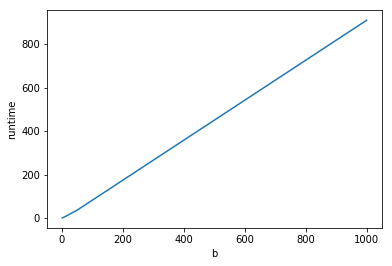

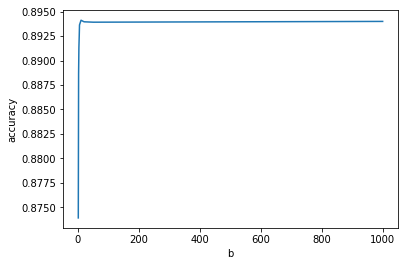

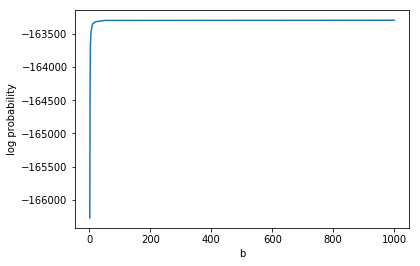

In [20]:
import matplotlib.pyplot as plt
plt.plot(bs,runtimes)
plt.xlabel("b")
plt.ylabel("runtime")
plt.show()

plt.plot(bs,accs)
plt.xlabel("b")
plt.ylabel("accuracy")
plt.show()

plt.plot(bs, log_probs)
plt.xlabel("b")
plt.ylabel("log probability")
plt.show()

## Comment:
It seems that when $b = 10$ we have the best accuracy